In [1]:
import os.path
import numpy as np
from numpy import fft
import scipy.ndimage as ndi
import skimage as ski
from skimage import io
from skimage import feature
from skimage import filters
from skimage import color
from skimage import segmentation
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2

if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

from ImageProcessingF2021.video import run_video

mpl.rcParams['figure.figsize'] = (10,10)
plt.gray();

Already up to date.


<Figure size 720x720 with 0 Axes>

In [2]:
def equalizeHistogram(im, clahe=None):
    """
    This applies histogram qualization to the luminance of the given color image (which must be
    grayscale or RGB). The luminance is essentially the grayscale of the image, but this applies
    it to that and then adjusts the color image to match that luminance.

    If this is provided with a CLAHE object, it is used to perform the CLAHE instead of global
    histogram equalization.
    """
    if im.ndim == 3 and im.shape[2] >= 3:
        ycrcb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)   # or color.rgb2ycbcr(im)
        if clahe is not None:
            ycrcb[:, :, 0] = clahe.apply(ycrcb[:, :, 0])
        else:
            ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])  # or exposure.equalize_hist(im)
        im = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)   # or color.ycbcr2rgb(im)
    else:  # assume grayscale
        im = cv2.equalizeHist(im) if clahe is None else clahe.apply(im)
    return im

In [3]:
lower1 = np.array([0, 39, 31], np.uint8)
upper1 = np.array([50, 255, 255], np.uint8)

lower2 = np.array([65, 98, 0], np.uint8)
upper2 = np.array([179, 255, 255], np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(21,21))

def image_in_range(im, colorized=True):
    """
    Returns a binary image where Trues (actually 255) in the result are when the HSV version is in the
    range of the global variables lower and upper.

    If colorized is True then the returned image has the pixels set to the color of the original image
    wherever the binary image is True.
    """
    he = equalizeHistogram(im, clahe)
    hsvim = cv2.cvtColor(he, cv2.COLOR_RGB2HSV)    # or color.rgb2hsv(im)
    mask = (cv2.inRange(hsvim, lower1, upper1) > 0) | (cv2.inRange(hsvim, lower2, upper2) > 0)  # or ((lower1 <= im).all(2) & (im <= upper1).all(2)) | ((lower2 <= im).all(2) & (im <= upper2).all(2))
    return color_mask(im, mask) if colorized else mask

def color_mask(im, mask):
    """
    Takes a color image and a mask and returns a new image that is black outside the mask but colored
    in the mask.
    """
    return mask[:, :, None] * im

In [5]:
im = run_video(camera_num=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01h\x08\x02\x00\x00\x00HP\xdd\x06\x…

In [6]:
im = run_video(image_in_range, camera_num=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01h\x08\x02\x00\x00\x00HP\xdd\x06\x…

In [15]:
def get_outline(im):
    im = im[: ,70:-70]
    seg = image_in_range(im)
    edges = feature.canny(color.rgb2gray(seg))
    edges = ndi.binary_dilation(edges)
    dilated = ndi.binary_opening(ndi.binary_closing(ndi.binary_opening((edges))))
    
    contours, _ = cv2.findContours(dilated.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=lambda x: cv2.contourArea(x))
    largest_contour = largest_contour.squeeze() # removes the random "1" dimension in the middle
    max_x, max_y = max(largest_contour[:,1]), max(largest_contour[:,0])
    min_x, min_y = min(largest_contour[:,1]), min(largest_contour[:,0])
    im = im[min_x:max_x, min_y:max_y]
    out = cv2.drawContours(im.copy(), [largest_contour-[[min_y,min_x]]], -1, (0,255,0), 2)
    return out

In [16]:
im = run_video(get_outline, camera_num=1, return_orig=True)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xd1\x00\x00\x01\x02\x08\x02\x00\x00\x00\xef\x85\…

In [9]:
def hand_segment(im):
    """
    Returns a binary image where Trues (actually 255) in the result are when the HSV version is in the
    range of the global variables lower and upper.

    If colorized is True then the returned image has the pixels set to the color of the original image
    wherever the binary image is True.
    """
    from ImageProcessingF2021 import cos

    try:
        intial_segmentation = image_in_range(im, False)

        # Get the largest contour
        contours, _ = cv2.findContours(intial_segmentation.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=lambda x: cv2.contourArea(x))
        largest_contour = largest_contour.squeeze() # removes the random "1" dimension in the middle
        out = cv2.drawContours(im.copy(), [largest_contour], -1, (0,255,0), 2)
        # Get the defects in the convex hull
        hull_indices = cv2.convexHull(largest_contour, returnPoints=False)
        defects = cv2.convexityDefects(largest_contour, hull_indices)
        defects = defects.squeeze() # removes the random "1" dimension in the middle

        # Filter the defects by the cos of their angle
        cos_angles = [cos(largest_contour[defect[2]], 
                    largest_contour[defect[1]], 
                    largest_contour[defect[0]]) for defect in defects]
        filtered_defects = [defect for defect, cos_angle in zip(defects, cos_angles) if cos_angle > 0]

        out = cv2.putText(im.copy(), f"{len(filtered_defects)+1}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0))

        # Optionally draw all of the other information
        out = cv2.drawContours(im.copy(), [largest_contour], -1, (0,255,0), 2)
        hull = cv2.convexHull(largest_contour)
        cv2.drawContours(out, [hull], -1, (0, 0, 255), 2)
        for i, (start, end, defect, distance) in enumerate(filtered_defects):
            cv2.line(out, largest_contour[start], largest_contour[defect], (255, 0, 0))
            cv2.line(out, largest_contour[end], largest_contour[defect], (255, 0, 0))
            cv2.circle(out, largest_contour[start], 2, (255, 0, 0), -1)
            cv2.circle(out, largest_contour[end], 2, (255, 0, 0), -1)
            cv2.circle(out, largest_contour[defect], 2, (255, 0, 0), -1)
            # cv2.putText(out, str(i), largest_contour[start], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
            # cv2.putText(out, f"{distance/256:.4}", largest_contour[defect], cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        
        return out
    except (cv2.error, ValueError, AttributeError, IndexError) as error:
        return im

# im = run_video(hand_segment, camera_num=1, return_orig=True)

In [90]:
# Code to save every frame
i = 0
def saver(im):
    global i
    while i < 40:
        outlined = get_outline(im[20:-20, 20:-30])
        if i % 2 == 0:
            io.imsave(f'alphabet/c/frame{i}.png', outlined)
        i += 1
        return outlined
    return im

In [33]:
# im = run_video(saver, camera_num=1);

/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_33455/1060158290.py:8: UserWarning: alphabet/c/frame0.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'alphabet/c/frame{i}.png', outlined)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02N\x00\x00\x01@\x01\x00\x00\x00\x00b\xc0\xce\xb5\x…

/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_33455/1060158290.py:8: UserWarning: alphabet/c/frame2.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'alphabet/c/frame{i}.png', outlined)
/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_33455/1060158290.py:8: UserWarning: alphabet/c/frame4.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'alphabet/c/frame{i}.png', outlined)
/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_33455/1060158290.py:8: UserWarning: alphabet/c/frame6.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'alphabet/c/frame{i}.png', outlined)
/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_33455/1060158290.py:8: UserWarning: alphabet/c/frame8.png is a

In [16]:
def digit_feature_vectors(im):
    """
    This is a very simple feature vector set: just the pixel values in their original order
    (after forcing the image size to be 18x18).
    """
    contours, _ = cv2.findContours(im.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=lambda x: cv2.contourArea(x))
    largest_contour = largest_contour.squeeze() # removes the random "1" dimension in the middle
    im.
    largest_contour

    return cv2.resize(im, (320, 590)).ravel()

def extract_training_digits(im, fv=digit_feature_vectors):
    """
    Extracts the training digits from the given image. The image must have 10 rows with
    each row a different numeral but the same height. The digits must be square. Every
    digit image is sent to the given feature vector function which must return a 1D
    set of values that are the features for that image. The same function will later be
    used to make the feature vectors for the digits being identified.
    
    This returns two arrays:
        feature_vectors: NxM where N is # examples and M is # features for each example
        labels:          Nx1
    """
    feature_vectors = []
    labels = []
    src_height = im.shape[0] // 3 #26 for full alphabet
    src_width = im.shape[1] // 20

    # height 320
    # width 590

    count = im.shape[1] // src_width
    for digit in range(3):
        row = im[digit*src_height:(digit+1)*src_width]
        for i in range(count):
            single_digit = row[:, i*src_width:(i+1)*src_width]
            feature_vectors.append(fv(single_digit))
            labels.append(digit)


    return np.array(feature_vectors, dtype=np.float32), np.array(labels).reshape(-1, 1)

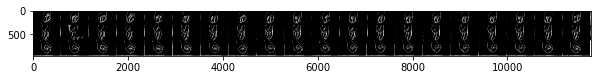

In [52]:
alphabet_im = io.imread('LabelsPage.png')[:, :, 0]
plt.imshow(alphabet_im)

In [53]:
fv, lbls = extract_training_digits(alphabet_im)

In [54]:
knn = cv2.ml.KNearest_create()
knn.train(fv, cv2.ml.ROW_SAMPLE, lbls)

True

In [24]:
fv.shape, fv.dtype

((60, 755200), dtype('float32'))

In [25]:
lbls.shape, lbls.dtype

((60, 1), dtype('int64'))

In [71]:
alphabet_im[:fv.shape[0]//3, :fv.shape[1]//20]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [70]:
test_im = io.imread('alphabet/a/frame0.png')

/var/folders/73/h6ppm6td6hx2rlm1103pksph0000gn/T/ipykernel_40345/1094991434.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  plt.imshow(test_im == alphabet_im[:alphabet_im.shape[0]//3, :alphabet_im.shape[1]//20])


TypeError: Invalid shape () for image data

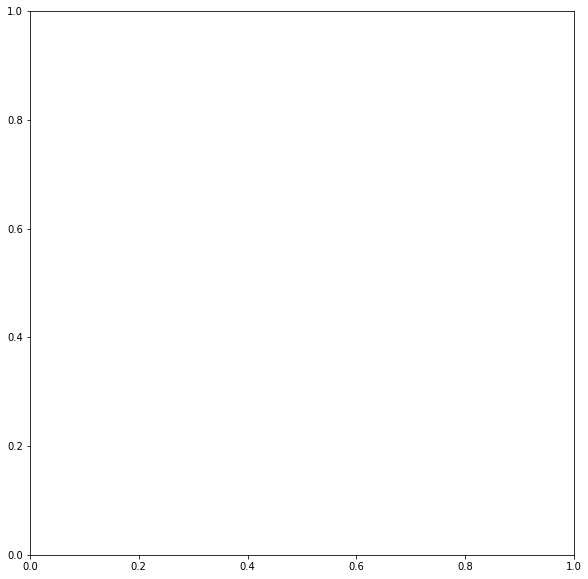

In [75]:
plt.imshow(test_im == alphabet_im[:alphabet_im.shape[0]//3, :alphabet_im.shape[1]//20])

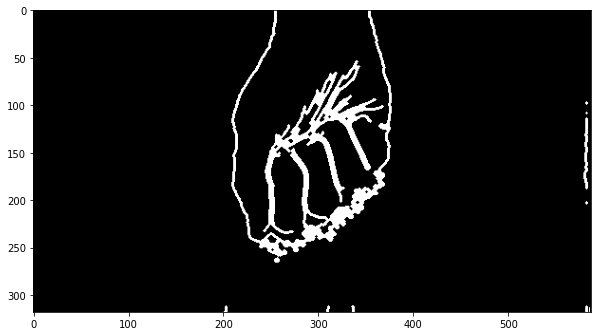

In [73]:
plt.imshow(alphabet_im[:alphabet_im.shape[0]//3, :alphabet_im.shape[1]//20])

In [76]:
test_im.shape

(320, 590)

In [77]:
alphabet_im.shape

(954, 11763)

In [68]:
_, digits, _, scores = knn.findNearest(digit_feature_vectors(test_im).astype(dtype=np.float32)[None, :], k=4)
print(digits, scores)

[[0.]] [[7.8283853e+08 7.8662554e+08 7.8877536e+08 7.9708166e+08]]


In [59]:
digit_feature_vectors(test_im).astype(dtype=np.float32)[None, :].shape

(1, 188800)

In [57]:
fv.shape

(60, 188800)

In [49]:
lbls.shape

(60, 1)

In [50]:
755200/188800

4.0

In [51]:
alphabet_im.shape

(954, 11763, 4)